# Problem 2

## Data Import
First, download the movielens (small) [dataset](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip) as `pandas.DataFrame` objects.

In [6]:
import pandas as pd

path = "Misc_files/movielens_data/ml-latest-small/"
# path = ""


# load movies and ratings DataFrames
movies = pd.read_csv(path+"movies.csv", header=0)
ratings = pd.read_csv(path+"ratings.csv", header=0)

In [7]:
# For the debugging

movies = movies[:1000]

We can then use the `head()` method to see the raw format of these `DataFrame` objects.

In [8]:
n_movies = len(movies)

print(f"Number of Unique Movies: {n_movies}")
movies.head()

Number of Unique Movies: 1000


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
n_ratings = len(ratings)
n_users = ratings.userId.nunique()
n_rated_movies = ratings.movieId.nunique()

print(f"Number of Ratings: {n_ratings}\nNumber of Users: {n_users}\nNumber of Unique Rated Movies: {n_rated_movies}")
ratings.head()

Number of Ratings: 100836
Number of Users: 610
Number of Unique Rated Movies: 9724


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Upon inspection of the raw data we note that of the 9,742 movies in the `movies` DataFrame, only 9,724 movies have been rated.

## Preprocessing

### Embedding Matrix $X$
To obtain the concurrent number of likes $X_{i,j}$ we must first binary encode (`0` or `1`) each `"rating"` in the `ratings` DataFrame. Let us encode the value of liking a movie for each review as such

$$ \text{Liked}(\text{Rating}) =
    \begin{cases}
        1 & \text{if Rating}\geq 4\\
        0 & \text{otherwise}
    \end{cases}$$

and store these values in a new `"liked"` column. We can subsequently drop the unnecessary `rating` and `timestamp` columns after this process.

In [10]:
import numpy as np

# create liked column
ratings["liked"] = np.where(ratings["rating"] >= 4, 1, 0)

# drop columns
ratings.drop(["rating", "timestamp"], axis=1, inplace=True)

We next create the `movie_ratings` DataFrame by joing the `movies` and `ratings` DataFrames. Setting the `merge` method parameter `how="left"` ensures that the original number of movies, 9,742, are maintained after the join.

In [11]:
# left join on movieId
movie_ratings = pd.merge(movies, ratings, how="left", on="movieId").reset_index()

A user-likes interaction matrix can then be constructed using the `pivot_table` method, whose rows correspond to the number of unique users `n_users` and columns correspond to the number of unique movies `n_movies` from the original data. This results in a sparse matrix whose rows summarize each users liked movies.

In [12]:
# pivot table on userId
user_likes = movie_ratings.pivot_table(values="liked", index="userId", columns="movieId", dropna=False, fill_value=0)

user_likes

movieId,1,2,3,4,5,6,7,8,9,10,...,1291,1292,1293,1295,1296,1297,1298,1299,1300,1301
userId,,,,,,,,,,,,,,,,,,,,,
1.0,1,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606.0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
607.0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
608.0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


Embedding matrix $X$ can now be constructed as the inner (dot) product of the transpose of `user_likes ` and itself. Element $X_{ij} \in X$ corresponds to the number of users that like both movie $i$ and $j$.

In [13]:
# convert to numpy ndarray for dot product computation
user_likes_array = user_likes.to_numpy()

# create X
X_embedding = np.dot(user_likes_array.T, user_likes_array)

# fill diagonals of X with zeros
np.fill_diagonal(X_embedding, 0)

# display as DataFrame for clarity
X_display = pd.DataFrame(X_embedding, index=movies.movieId, columns = movies.movieId)

X_display

movieId,1,2,3,4,5,6,7,8,9,10,...,1291,1292,1293,1295,1296,1297,1298,1299,1300,1301
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,21,11,0,7,27,7,1,4,19,...,47,7,10,2,6,8,5,12,3,4
2,21,0,5,0,4,8,6,0,0,9,...,16,0,2,1,1,2,1,1,1,2
3,11,5,0,0,4,4,5,1,2,3,...,3,1,0,0,0,2,3,2,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,7,4,4,0,0,3,4,1,1,2,...,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,8,2,2,0,0,2,1,0,0,2,...,9,1,1,0,2,0,3,4,1,0
1298,5,1,3,0,0,6,1,0,0,0,...,5,0,1,0,0,3,0,1,0,1
1299,12,1,2,0,0,4,0,0,0,1,...,6,7,6,2,5,4,1,0,3,1


## Model Architecture

With preprocessing completed, we convert embedding $X$ into a `torch` tensor object and construct cost function $c$.

In [14]:
import torch
from torch import mps

# make torch deterministic for reproducibility
torch.manual_seed(576)

# set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

X = torch.tensor(X_embedding, dtype = torch.float32)

We implement the below cost function:
$$c(v_1,\ldots, v_M)=\sum_{i=1}^M\sum_{j=1}^M 1_{[i\neq j]}(v_i^T v_j-X_{i,j})^2$$
by creating a superclass of the `torch` `nn.Module` class.

In [15]:
import torch.nn as nn

class cost_function(nn.Module):
    def __init__(self):
        super().__init__()

    @ classmethod
    def forward(self, v, X):
        # perform main cost function
        costs = ((1 - torch.eye(n_movies)) * (torch.mm(v.t(), v) - X)**2).sum()

        return costs

In [16]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def train(model, v, X, optimizer, n_epochs=100, verbose=10):
    costs = []  # Create a list to store the cost values at each epoch

    for epoch in tqdm(range(n_epochs)):
        # forward pass
        cost = model.forward(v, X)

        # backward pass
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        costs.append(cost.item())  # Append the cost value to the list
        if epoch % verbose == 0:
            print(f"Epoch: {epoch}\tCost: {cost:.5f}")

    return costs


# def train(model, v, X, optimizer, n_epochs=100, verbose=10):
#     costs = []  # Create a list to store the cost values at each epoch

#     for epoch in tqdm(range(n_epochs)):
#         # Clone the current state of 'v'
#         v_clone = v.clone().detach().requires_grad_(True)

#         # Forward pass
#         cost = model.forward(v_clone, X)

#         # Backward pass
#         optimizer.zero_grad()
#         cost.backward()
#         optimizer.step()

#         costs.append(cost.item())  # Append the cost value to the list
#         if epoch % verbose == 0:
#             print(f"Epoch: {epoch}\tCost: {cost:.5f}")

#     return costs, v_clone


Need to evaluate model on multiple hyper parameters:
different learning rates different optimizers – Adam and SGD

We need two different plots for costs/epoch iterations, one for Adam and one for SGD.

In [19]:
def plot_cost_history(costs, optimizer_name, lr):
    plt.figure()
    plt.plot(range(len(costs)), costs, marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title(f'{optimizer_name} Cost vs. Epoch, LR={lr}')
    plt.grid(True)
    plt.show()

def train_loop(optimizer_name, lr):
    import torch.optim as optim

    v = torch.normal(mean=0, std=0.5, size=(n_movies, n_movies), requires_grad=True)
    model = cost_function()
    model.to(device)

    if optimizer_name == 'Adam':
        optimizer = optim.Adam([v], lr)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD([v], lr)
    history = train(model, v, X, optimizer, 100)
    
    embedding = v.cpu().detach().numpy()

    # Plot the cost history
    plot_cost_history(history, optimizer_name, lr)

    return embedding, history

In [ ]:
# embedding1, history1 = train_loop(optimizer_name='Adam', lr=0.5)
# embedding2, history2 = train_loop(optimizer_name='Adam', lr=1e-1)
# history3 = train_loop(optimizer_name='Adam', lr=1e-2)

# history4 = train_loop(optimizer_name='SGD', lr=1e-5)
# history5 = train_loop(optimizer_name='SGD', lr=1e-6)
# history6 = train_loop(optimizer_name='SGD', lr=1e-7)

# Recommendation system

In [28]:
def train_loop(optimizer_name, lr):
    import torch.optim as optim

    v = torch.normal(mean=0, std=0.5, size=(n_movies, n_movies), requires_grad=True)
    model = cost_function()
    model.to(device)

    if optimizer_name == 'Adam':
        optimizer = optim.Adam([v], lr)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD([v], lr)
    history = train(model, v, X, optimizer, 100)
    
    embedding = v.cpu().detach().numpy()

    # Plot the cost history
    plot_cost_history(history, optimizer_name, lr)

    return embedding, history

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0	Cost: 75943080.00000
Epoch: 10	Cost: 3505387.50000
Epoch: 20	Cost: 1089266.50000
Epoch: 30	Cost: 345610.15625
Epoch: 40	Cost: 121236.90625
Epoch: 50	Cost: 43641.00781
Epoch: 60	Cost: 16815.34570
Epoch: 70	Cost: 6531.83887
Epoch: 80	Cost: 2636.79175
Epoch: 90	Cost: 1187.19873


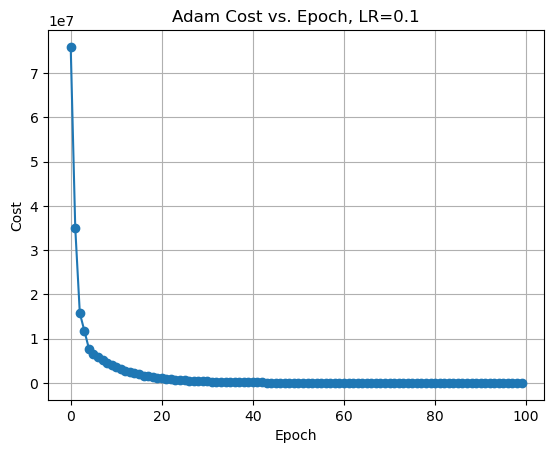

In [29]:
# embedding1, history1 = train_loop(optimizer_name='Adam', lr=0.5)
embedding2, history2 = train_loop(optimizer_name='Adam', lr=1e-1)
# history3 = train_loop(optimizer_name='Adam', lr=1e-2)

# history4 = train_loop(optimizer_name='SGD', lr=1e-5)
# history5 = train_loop(optimizer_name='SGD', lr=1e-6)
# history6 = train_loop(optimizer_name='SGD', lr=1e-7)

In [26]:
# Calculate movie similarities using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between movie embeddings
movie_similarities = cosine_similarity(embedding2)

# Function to recommend top N movies based on input movies
def recommend_movies(input_movies, movie_names, movie_similarities, top_n=10):
    # Find the indices of input movies
    input_indices = [movie_names.index(movie) for movie in input_movies]

    # Calculate the average similarity scores for input movies
    input_similarity_scores = np.mean(movie_similarities[input_indices], axis=0)

    # Exclude input movies from consideration
    for index in input_indices:
        input_similarity_scores[index] = -1.0  # Set similarity score to a negative value

    # Get indices of top N recommended movies
    top_indices = np.argsort(input_similarity_scores)[-top_n:][::-1]

    # Get the names of recommended movies
    recommended_movies = [movie_names[i] for i in top_indices]

    return recommended_movies

In [27]:
# Define the input movies
input_movies = ["Apollo 13 (1995)", "Toy Story (1995)", "Home Alone (1990)"]

# Get recommended movies
recommended_movies = recommend_movies(input_movies, movies['title'].tolist(), movie_similarities)

# Print the recommended movies
print("Recommended Movies:")
for i, movie in enumerate(recommended_movies, start=1):
    print(f"{i}. {movie}")

Recommended Movies:
1. Rosencrantz and Guildenstern Are Dead (1990)
2. Next Karate Kid, The (1994)
3. Fox and the Hound, The (1981)
4. Ruby in Paradise (1993)
5. On Golden Pond (1981)
6. Ninotchka (1939)
7. Star Wars: Episode V - The Empire Strikes Back (1980)
8. Trust (1990)
9. Inspector General, The (1949)
10. Demolition Man (1993)
